# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [5]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [6]:
!git clone -b spring21 https://github.com/ReddyNick/Practical_DL.git

Cloning into 'Practical_DL'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 3032 (delta 20), reused 6 (delta 3), pack-reused 2997
Receiving objects: 100% (3032/3032), 173.95 MiB | 41.24 MiB/s, done.
Resolving deltas: 100% (1588/1588), done.


In [7]:
cd Practical_DL/homework01/

/content/Practical_DL/homework01


# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [8]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

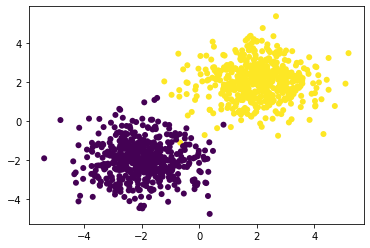

In [9]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [10]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [12]:
from tqdm import trange

In [13]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in trange(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

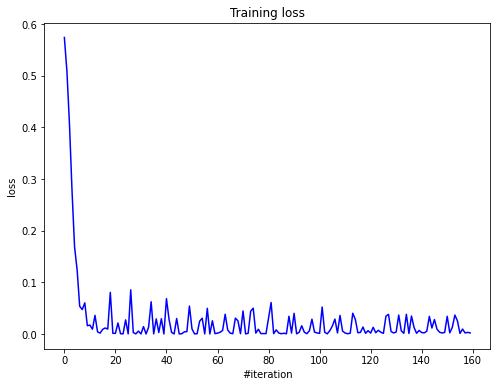

Current loss: 0.002082


In [14]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [16]:
import mnist 
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [18]:
# Your code goes here. ################################################
def one_hot_encode(labels):
    unique = np.unique(labels)
    encoded = np.zeros((len(labels), len(unique)))
    
    for idx in range(len(labels)):
        encoded[idx] = unique == labels[idx]

    return encoded

In [19]:
Y_train_onehot = one_hot_encode(y_train)
Y_val_onehot = one_hot_encode(y_val)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [17]:
net_relu = Sequential()
net_relu.add(Linear(X_train.shape[1], 100))
net_relu.add(ReLU())
net_relu.add(Linear(100, 200))
net_relu.add(ReLU())
net_relu.add(Linear(200, 10))
net_relu.add(LogSoftMax())

net_leaky_relu = Sequential()
net_leaky_relu.add(Linear(X_train.shape[1], 100))
net_leaky_relu.add(LeakyReLU(0.3))
net_leaky_relu.add(Linear(100, 200))
net_leaky_relu.add(LeakyReLU(0.3))
net_leaky_relu.add(Linear(200, 10))
net_leaky_relu.add(LogSoftMax())

net_Elu = Sequential()
net_Elu.add(Linear(X_train.shape[1], 100))
net_Elu.add(ELU(0.3))
net_Elu.add(Linear(100, 200))
net_Elu.add(ELU(0.3))
net_Elu.add(Linear(200, 10))
net_Elu.add(LogSoftMax())

net_softplus = Sequential()
net_softplus.add(Linear(X_train.shape[1], 100))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(100, 200))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(200, 10))
net_softplus.add(LogSoftMax())


nets = {"ReLu": net_relu, "LeakyReLu": net_leaky_relu, 
        "ELU": net_Elu, "SoftPlus": net_softplus}

criterion = ClassNLLCriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.0}
optimizer_state = {}

# Looping params
n_epoch = 21
batch_size = 100

In [18]:
import timeit

In [19]:
train_log = []
val_log = []
times = []

for name, net in nets.items():
    train_loss = []
    val_loss = []

    start_time = timeit.default_timer()

    for epoch in range(n_epoch):

        print(f"\nTraining {name} net: {epoch} epoch\n")

        for x_batch, y_batch in get_batches((X_train, Y_train_onehot), batch_size):
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)

        train_loss.append(criterion.forward(net.forward(X_train), Y_train_onehot))
        val_loss.append(criterion.forward(net.forward(X_val), Y_val_onehot))
        
        display.clear_output()

    end_time = timeit.default_timer()

    train_log.append(train_loss)
    val_log.append(val_loss)
    times.append(end_time - start_time) 

In [124]:
alpha_batch_norm = 0.8

net_relu = Sequential()
net_relu.add(Linear(X_train.shape[1], 100))
net_relu.add(BatchNormalization(alpha_batch_norm))
net_relu.add(ChannelwiseScaling(100))
net_relu.add(ReLU())
net_relu.add(Linear(100, 200))
net_relu.add(BatchNormalization(alpha_batch_norm))
net_relu.add(ChannelwiseScaling(200))
net_relu.add(ReLU())
net_relu.add(Linear(200, 10))
net_relu.add(LogSoftMax())

net_leaky_relu = Sequential()
net_leaky_relu.add(Linear(X_train.shape[1], 100))
net_leaky_relu.add(BatchNormalization(alpha_batch_norm))
net_leaky_relu.add(ChannelwiseScaling(100))
net_leaky_relu.add(LeakyReLU(0.3))
net_leaky_relu.add(Linear(100, 200))
net_leaky_relu.add(BatchNormalization(alpha_batch_norm))
net_leaky_relu.add(ChannelwiseScaling(200))
net_leaky_relu.add(LeakyReLU(0.3))
net_leaky_relu.add(Linear(200, 10))
net_leaky_relu.add(LogSoftMax())

net_Elu = Sequential()
net_Elu.add(Linear(X_train.shape[1], 100))
net_Elu.add(BatchNormalization(alpha_batch_norm))
net_Elu.add(ChannelwiseScaling(100))
net_Elu.add(ELU(0.3))
net_Elu.add(Linear(100, 200))
net_Elu.add(BatchNormalization(alpha_batch_norm))
net_Elu.add(ChannelwiseScaling(200))
net_Elu.add(ELU(0.3))
net_Elu.add(Linear(200, 10))
net_Elu.add(LogSoftMax())

net_softplus = Sequential()
net_softplus.add(Linear(X_train.shape[1], 100))
net_softplus.add(BatchNormalization(alpha_batch_norm))
net_softplus.add(ChannelwiseScaling(100))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(100, 200))
net_softplus.add(BatchNormalization(alpha_batch_norm))
net_softplus.add(ChannelwiseScaling(200))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(200, 10))
net_softplus.add(LogSoftMax())


nets = {"ReLu": net_relu, "LeakyReLu": net_leaky_relu, 
        "ELU": net_Elu, "SoftPlus": net_softplus}

criterion = ClassNLLCriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.0}
optimizer_state = {}

# Looping params
n_epoch = 21
batch_size = 100

In [125]:
train_batchnorm_log = []
val_batchnorm_log = []
times_batchnorm = []

for name, net in nets.items():
    train_loss = []
    val_loss = []

    start_time = timeit.default_timer()

    for epoch in range(n_epoch):

        print(f"\nTraining {name} net: {epoch} epoch\n")
        net.train()
        for x_batch, y_batch in get_batches((X_train, Y_train_onehot), batch_size):
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)

        net.evaluate()
        train_loss.append(criterion.forward(net.forward(X_train), Y_train_onehot))
        val_loss.append(criterion.forward(net.forward(X_val), Y_val_onehot))
        
        display.clear_output()

    end_time = timeit.default_timer()

    train_batchnorm_log.append(train_loss)
    val_batchnorm_log.append(val_loss)
    times_batchnorm.append(end_time - start_time) 

**Сравним score сетей с различными функциями активации**

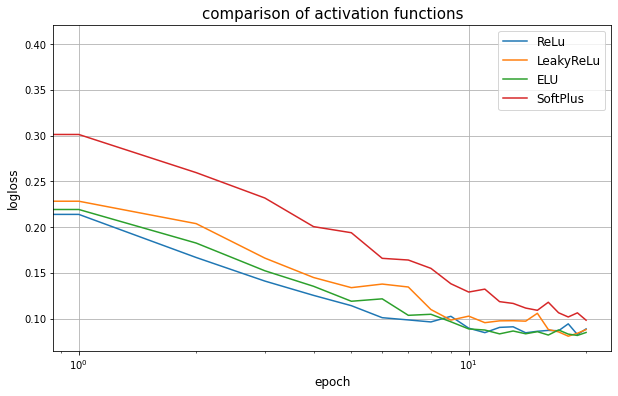

In [96]:
plt.figure(figsize=(10, 6))

for idx, name in enumerate(nets):
    plt.plot(val_log[idx], label=name)  

plt.xscale("log")
plt.legend(loc='best', fontsize=12)
plt.grid()

plt.title("comparison of activation functions", fontsize=15)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("logloss", fontsize=12)
plt.show()

**Сравним score сетей с различными функциями активации и с batch normalization**

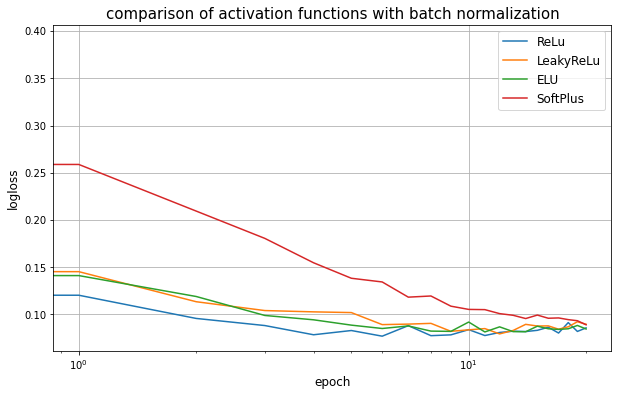

In [126]:
plt.figure(figsize=(10, 6))

for idx, name in enumerate(nets):
    plt.plot(val_batchnorm_log[idx], label=name)  

plt.xscale('log')

plt.legend(loc='best', fontsize=12)
plt.grid()

plt.title("comparison of activation functions with batch normalization", fontsize=15)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("logloss", fontsize=12)
plt.show()

**Сравним процессы обучения с процедурой batch normalization и без неё**

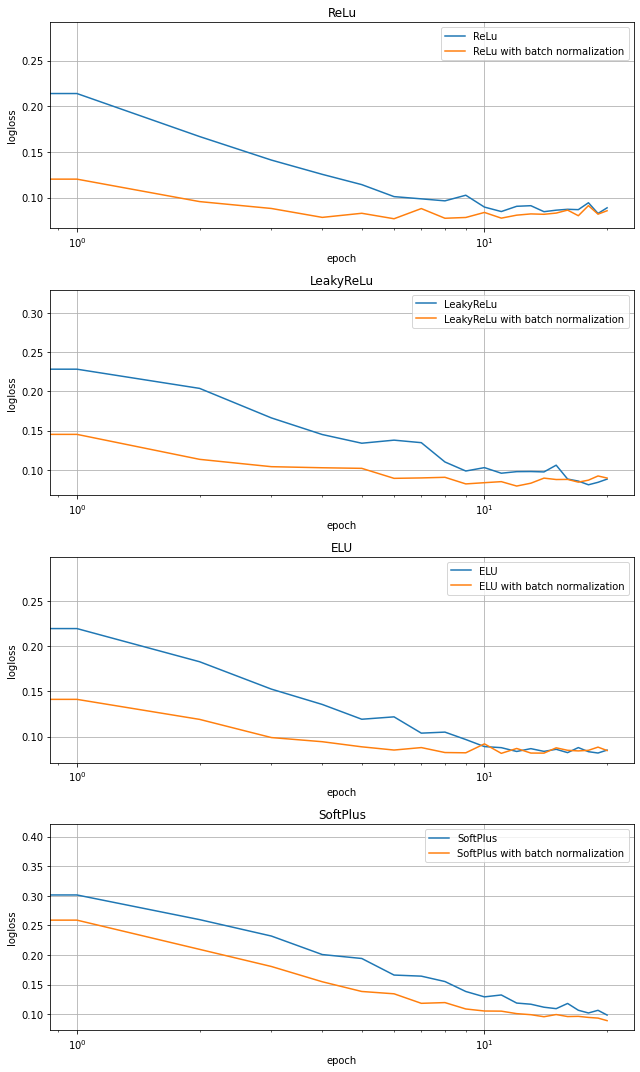

In [127]:
plt.figure(figsize=(9,15))

for idx, name in enumerate(nets.keys()):
    plt.subplot(4, 1, idx + 1)

    plt.plot(val_log[idx], label=name)
    plt.plot(val_batchnorm_log[idx], label=name + " with batch normalization")
    plt.xscale('log')

    plt.title(name)
    plt.legend(loc='best')
    plt.xlabel("epoch")
    plt.ylabel("logloss")
    plt.grid()

plt.tight_layout()

plt.show()

In [129]:
for idx, name in enumerate(nets.keys()):
    print(f"learning time {name}: {round(times[idx], 3)}s")

learning time ReLu: 86.745s
learning time LeakyReLu: 97.485s
learning time ELU: 109.908s
learning time SoftPlus: 132.005s


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Анализируя графики, можно сделать вывод, что для данной задачи и архитектуры сеть с функцией активации ReLu сходиться быстрее всех, c SoftMax медленнее всех.
Также видно, что процедура batch normalization действительно увеличивает скорость сходимости сети. Также ReLu легче всего для вычислений, для рассчета SoftMax требуется больше всего времени.**

**Momentum**

Epoch 14
Train loss: 0.005363592188714258
Val loss: 0.08227599661022104


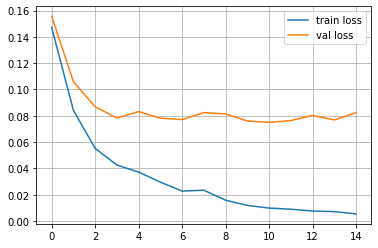

In [74]:
alpha_batch_norm = 0.8

net = Sequential()
net.add(Linear(X_train.shape[1], 100))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 200))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Optimizer params
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.4}
optimizer_state = {}

# Looping params
n_epoch = 15
batch_size = 100

train_mom_loss = []
val_mom_loss = []


for epoch in range(n_epoch):
    net.train()
    for x_batch, y_batch in get_batches((X_train, Y_train_onehot), batch_size):
        net.zeroGradParameters()
            
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
            
        # Update weights
        sgd_momentum(net.getParameters(), 
                    net.getGradParameters(), 
                    optimizer_config,
                    optimizer_state)

    net.evaluate()
    train_mom_loss.append(criterion.forward(net.forward(X_train), Y_train_onehot))
    val_mom_loss.append(criterion.forward(net.forward(X_val), Y_val_onehot))
    
    display.clear_output(wait=True)
    print("Epoch",epoch)
    print("Train loss:",train_mom_loss[-1])
    print("Val loss:",val_mom_loss[-1])
    plt.plot(train_mom_loss,label='train loss')
    plt.plot(val_mom_loss,label='val loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    

**Adam**

Epoch 14
Train loss: 0.00480507805300122
Val loss: 0.08574253449712343


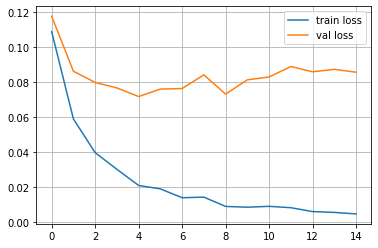

In [76]:
alpha_batch_norm = 0.8

net = Sequential()
net.add(Linear(X_train.shape[1], 100))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 200))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Optimizer params
optimizer_config = {'learning_rate': 0.001, 'beta1': 0.6, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state = {}

# Looping params
n_epoch = 15
batch_size = 100

train_adam_loss = []
val_adam_loss = []


for epoch in range(n_epoch):
    net.train()

    for x_batch, y_batch in get_batches((X_train, Y_train_onehot), batch_size):
        net.zeroGradParameters()
            
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
            
        # Update weights
        adam_optimizer(net.getParameters(), 
                    net.getGradParameters(), 
                    optimizer_config,
                    optimizer_state)

    net.evaluate()
    train_adam_loss.append(criterion.forward(net.forward(X_train), Y_train_onehot))
    val_adam_loss.append(criterion.forward(net.forward(X_val), Y_val_onehot))
        
    display.clear_output(wait=True)
    print("Epoch",epoch)
    print("Train loss:",train_adam_loss[-1])
    print("Val loss:",val_adam_loss[-1])
    plt.plot(train_adam_loss,label='train loss')
    plt.plot(val_adam_loss,label='val loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

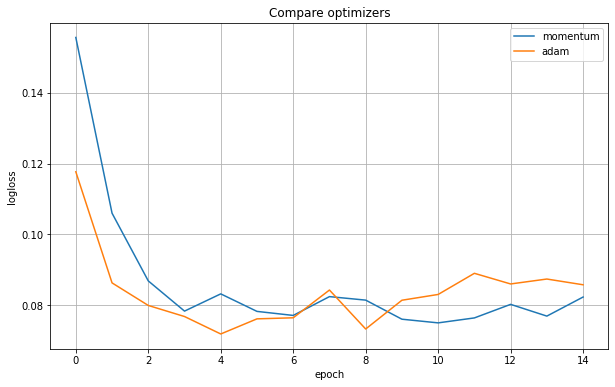

In [77]:
plt.figure(figsize=(10,6))

plt.plot(val_mom_loss, label='momentum')
plt.plot(val_adam_loss, label='adam')

# plt.xscale('log')

plt.title('Compare optimizers')
plt.legend(loc='best')
plt.xlabel("epoch")
plt.ylabel("logloss")
plt.grid()

plt.show()

**В данном случае momentum и adam показывают себя одинаково, однако я не уверен, что смог подобрать самые оптимальные параметры для каждого оптимизатора. Также можно увидеть, что с оптимизациями нейросеть начала переобучаться быстрее.**

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Epoch 13
Train loss: 0.012417976221158386
Val loss: 0.07060733793605767


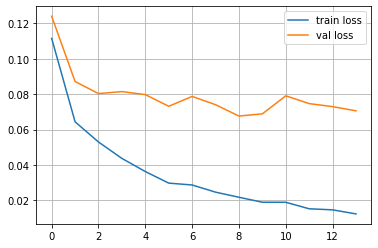

In [87]:
alpha_batch_norm = 0.8

net = Sequential()
net.add(Linear(X_train.shape[1], 100))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 200))
net.add(BatchNormalization(alpha_batch_norm))
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(200, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Optimizer params
optimizer_config = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state = {}

# Looping params
n_epoch = 14
batch_size = 32

train_loss = []
val_loss = []


for epoch in range(n_epoch):
    net.train()

    for x_batch, y_batch in get_batches((X_train, Y_train_onehot), batch_size):
        net.zeroGradParameters()
            
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
            
        # Update weights
        adam_optimizer(net.getParameters(), 
                    net.getGradParameters(), 
                    optimizer_config,
                    optimizer_state)

    net.evaluate()
    train_loss.append(criterion.forward(net.forward(X_train), Y_train_onehot))
    val_loss.append(criterion.forward(net.forward(X_val), Y_val_onehot))
        
    display.clear_output(wait=True)
    print("Epoch",epoch)
    print("Train loss:",train_loss[-1])
    print("Val loss:",val_loss[-1])
    plt.plot(train_loss,label='train loss')
    plt.plot(val_loss,label='val loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [108]:
probabilities = np.exp(net.forward(X_test))
y_pred = np.apply_along_axis(np.argmax, axis=1, arr=probabilities)

Print here your accuracy on test set. It should be around 90%.

In [112]:
accuracy = np.array(y_test == y_pred).astype(int).mean()
print(f"accuracy = {accuracy}")

accuracy = 0.9798
